In [1]:
from astropy.wcs import WCS
import astropy
import regions
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
%matplotlib widget
from spectral_cube import SpectralCube
from radio_beam.beam import NoBeamException
from radio_beam import Beam
from matplotlib.transforms import Affine2D
from astropy import units
from astropy.visualization import AsinhStretch

# from traceback_with_variables import activate_in_ipython_by_import
# For emergencies

In [2]:
font = {'size'   : 14}
matplotlib.rc('figure',figsize=(7.5,4.5))
matplotlib.rc('font',**font)
matplotlib.rc('image',interpolation='none') # helps with up-sampled images and pdf files
plt.rcParams['figure.constrained_layout.use'] = True
# plt.rcParams.update({
#     "text.usetex": True,
#     "text.latex.preamble": "\\usepackage[lf]{ebgaramond}\\usepackage{ebgaramond-maths}",
#     "font.family": "ebgaramond"
# })
# plt.style.use("dark_background")
# font = {'size'   : 10,
#    'family': ["Nimbus Roman"]}
# idk why this stopped working
matplotlib.rc('figure',figsize=(3.5,2))
matplotlib.rc('font',**font)



In [3]:
# Download files from here: https://exchg.calet.org/cosmosweb-public/DR0.5/NIRCam/Apr23/extensions/
# Astropy can supposedly read gz files but I strongly recommend you unzip them. 
# These fits are 2 GB each so no way can they go on GitHub
# Would be nice if I could get it to download just a cutout, but even though astropy is supposedly capable
# I could not figure out how to make it work usefully

jwst11=fits.open("../../jwst/mosaic_nircam_f115w_COSMOS-Web_30mas_A3_v0_5_sci.fits")
jwst15=fits.open("../../jwst/mosaic_nircam_f150w_COSMOS-Web_30mas_A3_v0_5_sci.fits")
jwst27=fits.open("../../jwst/mosaic_nircam_f277w_COSMOS-Web_30mas_A3_v0_5_sci.fits")
# jwst44=fits.open("JWST/jw01727-o099_t093_nircam_clear-f444w_i2d.fits")

In [4]:
def get_pixel_scale(spectral_cube):
    """ Given a spectral cube, compute the size of a pixel 
    in degrees """
    if spectral_cube.wcs.pixel_scale_matrix[1,0] != 0 or abs(spectral_cube.wcs.pixel_scale_matrix[1,1]) != abs(spectral_cube.wcs.pixel_scale_matrix[0,0]):
        print("Warning: pixel scale is not square")
    a = abs(spectral_cube.wcs.pixel_scale_matrix[1,1])
    return a*units.deg

def get_plot_ellipse(spectral_cube,x,y,color,target_wcs=None):
    """ Given a spectral cube, extract its beam and create an ellipse
    from it. The ellipse will be placed at x,y """
    if type(spectral_cube) is SpectralCube:
        beam = spectral_cube.beam
        wcs = spectral_cube.wcs
    elif type(spectral_cube) is fits.hdu.image.PrimaryHDU or type(spectral_cube) is fits.hdu.image.ImageHDU:
        beam = Beam.from_fits_header(spectral_cube.header)
        wcs = WCS(spectral_cube.header)
    elif type(spectral_cube) is astropy.nddata.utils.Cutout2D:
        raise NoBeamException()
    else:
        raise RuntimeError("Unsupported argument type. We support spectral cubes and fits PrimaryHDUs")
        
    if target_wcs is not None:
        wcs = target_wcs
        
    el = beam.ellipse_to_plot(x,y,wcs.pixel_scale_matrix[1,1]*units.deg)
    el.set_color(color)
    return(el)


def wcsfig(cube,
           elx=100,
           ely=100,
           elc='w',
           pre_el_patches=None,
           axis_labels_dict={
               "dec":['DEC (J2000)',{'minpad':-0.4}],
               "ra":['RA (J2000)',{}]
           }, # This is unwieldy but I think it's the best I've come up with
           **kwargs
          ):
    """ Magic function, which, given a spectral cube, returns a 
    figure and axis that you can use to plot the spectral cube with
    physical coordinates. This also takes care of plotting the 
    beam ellipse if the spectral cube has beam parameters"""
    fig = plt.figure(**kwargs)
    if type(cube) is SpectralCube:
        proj = cube.wcs.dropaxis(2)
    elif type(cube) is fits.hdu.image.PrimaryHDU or type(cube) is fits.hdu.image.ImageHDU:
        proj = get_wcs(cube)
    elif type(cube) is astropy.nddata.utils.Cutout2D:
        proj = cube.wcs
    else:
        raise RuntimeError("Unsupported argument type. We support spectral cubes and fits PrimaryHDUs and cutout2ds")
    ax = fig.add_subplot(111,projection=proj)
    
    if pre_el_patches is not None:
        if type(pre_el_patches) is list:
            for patch in pre_el_patches:
                ax.add_patch(patch)
        else:
            ax.add_patch(pre_el_patches)
    
    try:
        e = get_plot_ellipse(cube,elx,ely,elc)
        ax.add_patch(e)
    except NoBeamException:
        print("No beam found, not plotting beam ellipse")
    if axis_labels_dict is not None:
        for key in axis_labels_dict:
            ax_transform = ax.coords[key]
            params = axis_labels_dict[key]
            ax_transform.set_axislabel(params[0], **params[1])
    return fig,ax

def get_wcs(fitshdu):
    """ Return a wcs object from a fits HDU object """
    return WCS(fitshdu.header,naxis=["longitude","latitude"])

In [5]:
# fig,ax=wcsfig(jwst11[1])
# im=ax.imshow(jwst11[1].data)
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# im.set_norm(norm)

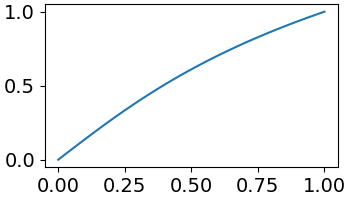

In [6]:
plt.figure()
x = np.linspace(0,1,100)
y = AsinhStretch(0.5)(x)
plt.plot(x,y)

In [7]:
w=get_wcs(jwst11[0])
w.wcs.get_cdelt()

array([8.33333333e-06, 8.33333333e-06])

In [8]:
ang=np.arccos(w.wcs.pc[1][1])

In [9]:
def arcsinh_color(data, min, max):
    # pre-stretch the data so that data==min -> 0 and data==max -> 1
    data = data - min
    data[data<0] = 0
    data = data / (max - min)
    data[data>1] = 1
    return AsinhStretch()(data)

In [10]:
def getcutout(jwst):
    wcs = WCS(jwst[0].header)
    position = SkyCoord('10h00m38s 02d08m22.4s')
    size = 9 * units.arcsec
    cutout = astropy.nddata.Cutout2D(
        jwst[0].section,  # use `.section` rather than `.data`!
        position=position,
        size=size,
        wcs=wcs
    )
    return cutout

In [11]:
rcutout = getcutout(jwst27)
gcutout = getcutout(jwst15)
bcutout = getcutout(jwst11)

r = arcsinh_color(rcutout.data, 0, 2.355)
g = arcsinh_color(gcutout.data, 0.03, 1.353)
b = arcsinh_color(bcutout.data, 0.028, 0.942)
r[np.isnan(r)]=1

In [12]:
rgb = np.empty(r.shape + (3,), dtype=int)

In [13]:
rgb.shape

(300, 300, 3)

In [14]:
rgb = np.empty(r.shape + (3,), dtype=float)
rgb[:,:,0] = r
rgb[:,:,1] = g
rgb[:,:,2] = b

In [15]:
c = rcutout

No beam found, not plotting beam ellipse


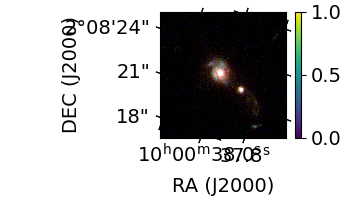

In [16]:
fig,ax=wcsfig(c)

imgdata=rgb
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)


tr = Affine2D().rotate_around(c.wcs.wcs.crpix[0],c.wcs.wcs.crpix[1],ang)

im=ax.imshow(imgdata)#, transform=tr + ax.transData)
im.set_norm(norm)
fig.colorbar(im)

In [24]:
0.951**2 + 0.3077**2

0.9990802899999999

In [25]:
import mpl_toolkits.axes_grid1.anchored_artists

In [26]:
mpl_toolkits.axes_grid1.anchored_artists.__dir__()

['__name__',
 '__doc__',
 '__package__',
 '__loader__',
 '__spec__',
 '__file__',
 '__cached__',
 '__builtins__',
 'transforms',
 'AnchoredOffsetbox',
 'AuxTransformBox',
 'DrawingArea',
 'TextArea',
 'VPacker',
 'Rectangle',
 'ArrowStyle',
 'FancyArrowPatch',
 'PathPatch',
 'TextPath',
 '__all__',
 'AnchoredDrawingArea',
 'AnchoredAuxTransformBox',
 'AnchoredSizeBar',
 'AnchoredDirectionArrows']

In [27]:
w = c.wcs
wcs_rotated = WCS(naxis=2)
wcs_rotated.wcs.crpix = w.wcs.crpix
wcs_rotated.wcs.crval = w.wcs.crval
wcs_rotated.wcs.cunit = ["deg", "deg"]
wcs_rotated.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wcs_rotated.wcs.cdelt = w.wcs.get_cdelt()*np.array([-1,1])

In [28]:
w.wcs.get_cdelt()*np.array([-1,1])

array([-8.33333333e-06,  8.33333333e-06])

In [29]:
linefits= astropy.io.fits.open("../data/SDSSJ1000_CII_mom0_pbcor.fits")
lineimage=linefits[0].data[0][0]

contfits = astropy.io.fits.open("../data/SDSSJ1000_cont_pbcor.fits")
contimage=contfits[0].data[0][0]

linecube = SpectralCube.read(linefits)

In [30]:
def plot_everything():
    #warning: relies on global variables.
    fig = plt.figure(figsize=(6,4.2))
    ax = fig.add_subplot(111,projection=wcs_rotated)
    tr = Affine2D().rotate_around(w.wcs.crpix[0],w.wcs.crpix[1],ang)
    
    im=ax.imshow(rgb, transform=tr + ax.transData)

    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("DEC (J2000)", labelpad=-0.4)
    
    levels = np.array((2, 4, 6, 8))*0.684
    alma_transform = ax.get_transform(WCS(linefits[0].header,naxis=["longitude","latitude"]))
    ax.contour(lineimage, alpha=0.6, levels=levels,
               transform=alma_transform,colors='c',linewidths=1)
    
    e=get_plot_ellipse(linecube,locst[2][0],locst[2][1],'w',target_wcs=wcs_rotated)
    ax.add_patch(e)
    # the magic number below is dec_cdelt
    ax.add_patch(matplotlib.patches.Circle(locst[5],circle_dia/2,linestyle="--",linewidth=2,color="w",fill=False,alpha=0.5))
    
    ax.annotate("Tidal Tail",locst[6],locst[7],
                color='w',arrowprops={'color':'w','width':0.4,'headwidth':5,'headlength':5})
    ax.annotate("Bridge",locst[8],locst[9],
                color='w',arrowprops={'color':'w','width':0.4,'headwidth':5,'headlength':5})
    ax.annotate(r"D=2$^{\prime\prime}$",locst[10],locst[11],
                color='w',arrowprops={'color':'w','width':0.4,'headwidth':5,'headlength':5})
    
    
    plt.xlim(locs[0][0:2])
    plt.ylim(locs[1][0:2])

/Users/christopher/Library/CloudStorage/Dropbox/Documents/zeus2/SDSSJ1000/Rooney2025ApJ...987...61R/src/.venv/lib/python3.13/site-packages/ipympl/backend_nbagg.py:335: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  self.figure.savefig(buf, format='png', dpi='figure')
/Users/christopher/Library/CloudStorage/Dropbox/Documents/zeus2/SDSSJ1000/Rooney2025ApJ...987...61R/src/.venv/lib/python3.13/site-packages/ipympl/backend_nbagg.py:335: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  self.figure.savefig(buf, format='png', dpi='figure')


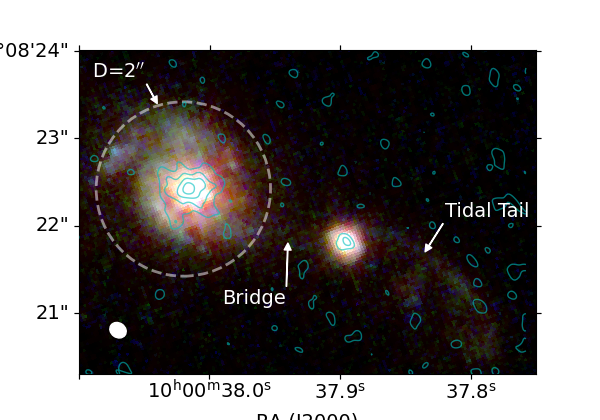

In [31]:
base = "10h00m{}s 02d08m{}s"
ll = base.format(38.1, 20.3)
ur = base.format(37.75,24.01)
beam_ellipse_pos = base.format(38.07,20.8)
circle_dia_1 = base.format(0,0)
circle_dia_2 = base.format(0,2)
circle_center = base.format(38.02,22.42)
tt_pointer = base.format(37.835,21.7)
tt_text = base.format(37.82,22.1)
bridge_pointer = base.format(37.940,21.8)
bridge_text = base.format(37.99,21.1)
circle_pointer = base.format(38.04,23.4)
circle_text = base.format(38.09,23.7)

sc = SkyCoord([
    ll, # 0
    ur, # 1
    beam_ellipse_pos, # 2
    circle_dia_1, # 3
    circle_dia_2, # 4
    circle_center, # 5
    tt_pointer, # 6
    tt_text, # 7
    bridge_pointer, # 8 
    bridge_text, # 9
    circle_pointer,
    circle_text
])
locs = wcs_rotated.world_to_pixel(sc)
locs = np.array(locs)
locst = locs.T # xkcd.com/797
circle_dia = (locst[4]-locst[3])[1]
plot_everything()

In [32]:
plt.savefig("jwst_annotated.png", dpi=300)

In [33]:
plt.savefig("jwst_annotated_new.pdf")

/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_16743/3840020243.py:8: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig("jwst_no_annot.png", dpi=300)
/var/folders/ck/hy5p5w_s1l12xprkbrgybk180000gn/T/ipykernel_16743/3840020243.py:8: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig("jwst_no_annot.png", dpi=300)


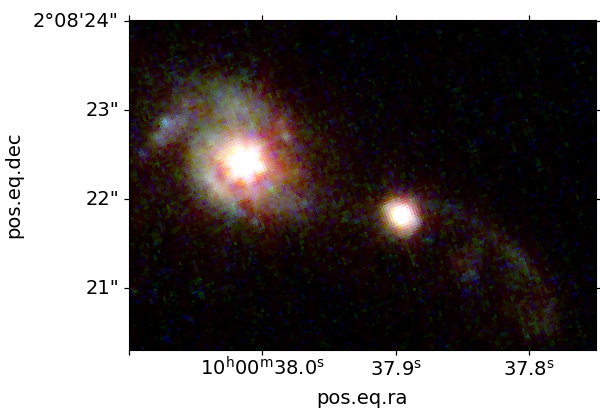

In [34]:
fig = plt.figure(figsize=(6,4.2))
ax = fig.add_subplot(111,projection=wcs_rotated)
tr = Affine2D().rotate_around(w.wcs.crpix[0],w.wcs.crpix[1],ang)

im=ax.imshow(rgb, transform=tr + ax.transData)
plt.xlim(locs[0][0:2])
plt.ylim(locs[1][0:2])
plt.savefig("jwst_no_annot.png", dpi=300)

In [39]:
gal_sat_coords = ["10h00m38.016s +02d08m22.43s","10h00m37.895s +02d08m21.82s"]
# gal_sat_xy = [[597,1032],[1095,875]] # old value
gal_sat_xy = [[546,648], [805,560]]
# color_wcs = astropy.wcs.utils.fit_wcs_from_points(
#     #(np.array([1200,1233]),np.array([885,801])), # rotate by ang
#     #(np.array([619,504]),np.array([1123,657])), # rotate by -ang
#     #(np.array([1411,1101]),np.array([474,893])), # no rotation
#     (np.array([595,1095]),np.array([1034,875])), # reverse engineered from future image
#     SkyCoord(gal_sat_coords)
# )
sc=SkyCoord(gal_sat_coords,frame="icrs")
ra_cdelt=-(sc[0].ra.value-sc[1].ra.value)/(gal_sat_xy[1][0]-gal_sat_xy[0][0])
dec_cdelt=(sc[0].dec.value-sc[1].dec.value)/(gal_sat_xy[0][1]-gal_sat_xy[1][1])

In [40]:
dec_cdelt

1.925505050505049e-06

In [41]:
wcs_rotated = WCS(naxis=2)
wcs_rotated.wcs.crpix = gal_sat_xy[0]
wcs_rotated.wcs.crval = (sc[0].ra.value  , sc[0].dec.value)
wcs_rotated.wcs.cunit = ["deg", "deg"]
wcs_rotated.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wcs_rotated.wcs.cdelt = [ra_cdelt,dec_cdelt]
wcs_rotated

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 150.15839999999997 2.139563888888889 
CRPIX : 546.0 648.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -1.9465894465031793e-06 1.925505050505049e-06 
NAXIS : 0  0

In [42]:
wcs_rotated.pixel_scale_matrix

array([[-1.94658945e-06,  0.00000000e+00],
       [ 0.00000000e+00,  1.92550505e-06]])

In [45]:
plt.close("all")